In [41]:
import numpy as np
import cv2 as cv
from tqdm import tqdm
import mrob
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
cap = cv.VideoCapture('video_2024-03-16_00-18-34.mp4')
# cap = cv.VideoCapture('table.mp4')

frameCount = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()

In [53]:
sift = cv.SIFT_create(nfeatures=1500)
orb = cv.ORB_create()

# bf = cv.BFMatcher()
bf = cv.BFMatcher(cv.NORM_HAMMING)

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50) # or pass empty dictionary
# flann = cv.FlannBasedMatcher(index_params,search_params)

keyframe_index = 0
frame_index = 0

keyframes = []

for frame_index in tqdm(range(buf.shape[0])):
    frame = buf[frame_index]
    # if frame is read correctly ret is True
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # kp, des = sift.detectAndCompute(gray,None)
    kp, des = orb.detectAndCompute(gray,None)

    if frame_index == 0:
        keyframe_kp = kp
        keyframe_des = des
        keyframe_img = gray
        keyframe_index = frame_index
        keyframes.append((keyframe_index, keyframe_kp, keyframe_img))

    if frame_index != 0:

        matches = bf.knnMatch(prev_des, des, k=2)
        keyframe_matches = bf.knnMatch(keyframe_des, des, k=2)

        # matches = flann.knnMatch(prev_des, des, k=2)
        # keyframe_matches = flann.knnMatch(keyframe_des, des, k=2)

        good = []
        for m,n in keyframe_matches:
            if m.distance < 0.75*n.distance:
                # good.append(m)
                good.append(m) 

        # img=cv.drawKeypoints(gray, kp, None)
        # cv.imshow('frame', img)      

        # cv.imshow('frame', cv.drawMatchesKnn(keyframe_img, keyframe_kp, gray, kp, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
        # if cv.waitKey(1) == ord('q'):
        #     break
                
        # print(len(good))
        if len(good) < 100:
        # if frame_index % 2 == 0:
            keyframe_kp = kp
            keyframe_des = des
            keyframe_index = frame_index
            keyframe_img = gray
            keyframes.append((keyframe_index, keyframe_kp, keyframe_img, good))

    prev_kp = kp
    prev_des = des
    prev_img = gray

cv.destroyAllWindows()

100%|██████████| 504/504 [00:20<00:00, 25.01it/s]


In [54]:
len(keyframes)

19

In [55]:
global_matches = []

for m in range(len(keyframes[1][3])):
    global_matches.append([keyframes[1][3][m].queryIdx, keyframes[1][3][m].trainIdx])

for kf in tqdm(range(2, len(keyframes))):
    for m in range(len(keyframes[kf][3])):
        found_match = False
        for global_match in global_matches:
            if global_match[-1] == keyframes[kf][3][m].queryIdx and len(global_match) != kf+1:
                global_match.append(keyframes[kf][3][m].trainIdx)
                found_match = True
        if not found_match:
            global_matches.append([-1] * (kf - 1) + [keyframes[kf][3][m].queryIdx, keyframes[kf][3][m].trainIdx])
            
    for global_match in global_matches:
        if len(global_match) < kf + 1:
            global_match.extend([-1])

assert len(keyframes) == min([len(x) for x in global_matches]) == max([len(x) for x in global_matches])

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 30.28it/s]


In [56]:
global_matches = np.array(global_matches)

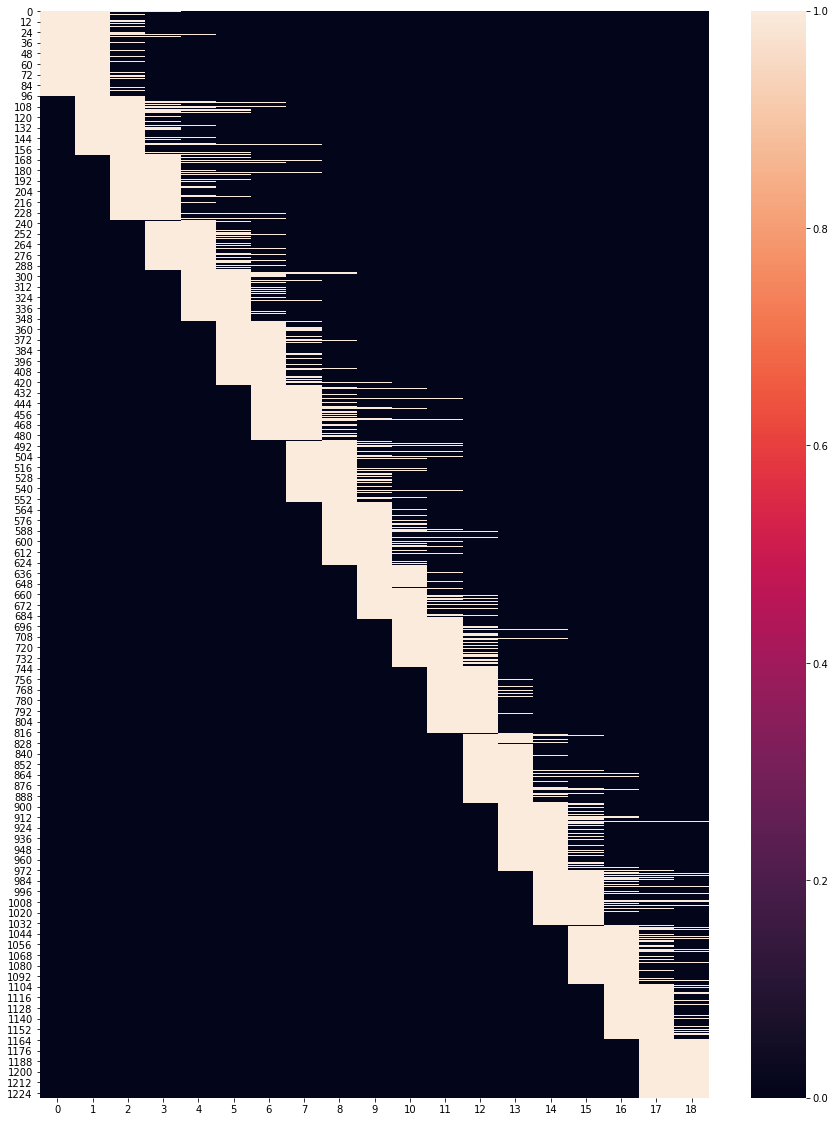

In [57]:
plt.figure(figsize=(15, 20))
sns.heatmap(np.where(global_matches > 0, 1, 0));

In [58]:
W = np.identity(2)

K = np.array([[1.23472227e+03, 0.00000000e+00, 6.38814655e+02],
              [0.00000000e+00, 1.23122213e+03, 3.37257425e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

camera_k = np.array([K[0, 0],
                     K[1, 1],
                     K[0, 2],
                     K[1, 2]])

In [59]:
graph = mrob.FGraph(mrob.HUBER)
global_matches_to_graph_id = {}
poses_indeces_in_graph = []

for kf in tqdm(range(len(keyframes))):

    if kf == 0:
        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
    else:
        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

    poses_indeces_in_graph.append(pose_id)

    # graph.add_factor_2poses_3d()
    # print(pose_id)
    
    for global_match_index in range(global_matches.shape[0]):

        if global_matches[global_match_index, kf] == -1:
            continue
        
        if not (global_match_index in global_matches_to_graph_id.keys()):
            l = graph.add_node_landmark_3d(np.random.random((3, 1)))
            global_matches_to_graph_id[global_match_index] = l
            
        graph.add_factor_camera_proj_3d_point(
                obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                nodePoseId = pose_id,
                nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                camera_k = camera_k,
                obsInvCov = W)
    
    graph.solve(mrob.LM)
        # print(global_match_index)

 16%|█▌        | 3/19 [00:00<00:00, 17.19it/s]

100%|██████████| 19/19 [00:04<00:00,  3.89it/s]


In [62]:
landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

<ipython-input-62-1089bd6a750f>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-62-1089bd6a750f>:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [63]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   mode='markers', marker_size=5)])
fig.show()
fig.write_html("feature_map.html")

In [52]:
fig = go.Figure(data=[go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   mode='markers')])
fig.show()

In [61]:
cv.solvePnPRansac?

Docstring:
solvePnPRansac(objectPoints, imagePoints, cameraMatrix, distCoeffs[, rvec[, tvec[, useExtrinsicGuess[, iterationsCount[, reprojectionError[, confidence[, inliers[, flags]]]]]]]]) -> retval, rvec, tvec, inliers
.   @brief Finds an object pose from 3D-2D point correspondences using the RANSAC scheme.
.   
.   @see @ref calib3d_solvePnP
.   
.   @param objectPoints Array of object points in the object coordinate space, Nx3 1-channel or
.   1xN/Nx1 3-channel, where N is the number of points. vector\<Point3d\> can be also passed here.
.   @param imagePoints Array of corresponding image points, Nx2 1-channel or 1xN/Nx1 2-channel,
.   where N is the number of points. vector\<Point2d\> can be also passed here.
.   @param cameraMatrix Input camera intrinsic matrix \f$\cameramatrix{A}\f$ .
.   @param distCoeffs Input vector of distortion coefficients
.   \f$\distcoeffs\f$. If the vector is NULL/empty, the zero distortion coefficients are
.   assumed.
.   @param rvec Output rotation ve

In [ ]:
global_matches = []

for m in range(len(keyframes[1][3])):
    global_matches.append([keyframes[1][3][m].queryIdx, keyframes[1][3][m].trainIdx])

for kf in tqdm(range(2, len(keyframes))):
    for m in range(len(keyframes[kf][3])):
        found_match = False
        for global_match in global_matches:
            if global_match[-1] == keyframes[kf][3][m].queryIdx and len(global_match) != kf+1:
                global_match.append(keyframes[kf][3][m].trainIdx)
                found_match = True
        if not found_match:
            global_matches.append([-1] * (kf - 1) + [keyframes[kf][3][m].queryIdx, keyframes[kf][3][m].trainIdx])
            
    for global_match in global_matches:
        if len(global_match) < kf + 1:
            global_match.extend([-1])

assert len(keyframes) == min([len(x) for x in global_matches]) == max([len(x) for x in global_matches])

for kf_1 in tqdm(range(len(keyframes))):
    for kf_2 in range(kf_1 + 1, len(keyframes)):
        kp, des = orb.detectAndCompute(gray, None)